## Vignette 1: The basics with the simple model.

### Importing PREFFECT into Python

In [1]:
import sys
import os
import numpy as np
import torch

sys.path.insert(0, '/data/lab_vm/release/')
from preffect import *

# it's good practice to limit threads used per runs
num_processors = 2
torch.set_num_threads(num_processors)
torch.set_num_interop_threads(num_processors)

----------

### Initializing the PREFFECT factory: 
The `factory()` function configures a session and controls the workflow for the user. Any parameter of the system can be set during initialization as per the example below. Parameters not modified during initiailization of the Factory() object have default values.

In [ ]:
preffect = factory(visualize=True,                                
            type='simple',   # set PREFFECT model {simple, single, full}
            model_likelihood = 'NB',   # NB or ZINB
            epochs = 1000, 
            mini_batch_size = 50 , # num. of samples per minibatch
            correct_vars = True, # specific variables to perform adustment
            vars_to_correct = [('batch', 'categorical')],
            X_recon_weight=100, # weights to expression reconstruction loss
            X_KL_weight=[0.1], # weights to expression KL divergence
            # path to folder storing your input (requires AnnData formatting)
            input_anndata_path = '/data/lab_vm/release/preffect/vignettes/simple/',
            # path to output folder
            output_path = '/data/lab_vm/release/preffect/vignettes/vignette_output/'
)

----------

### Training your PREFFECT Model:

When completed, PREFFECT will display a plot of all losses computed during training.

Additional plots can be found in your output path (set parameter: "output_path").

Training Progress: 100%|██████████| 2000/2000 [09:00<00:00,  3.70it/s]


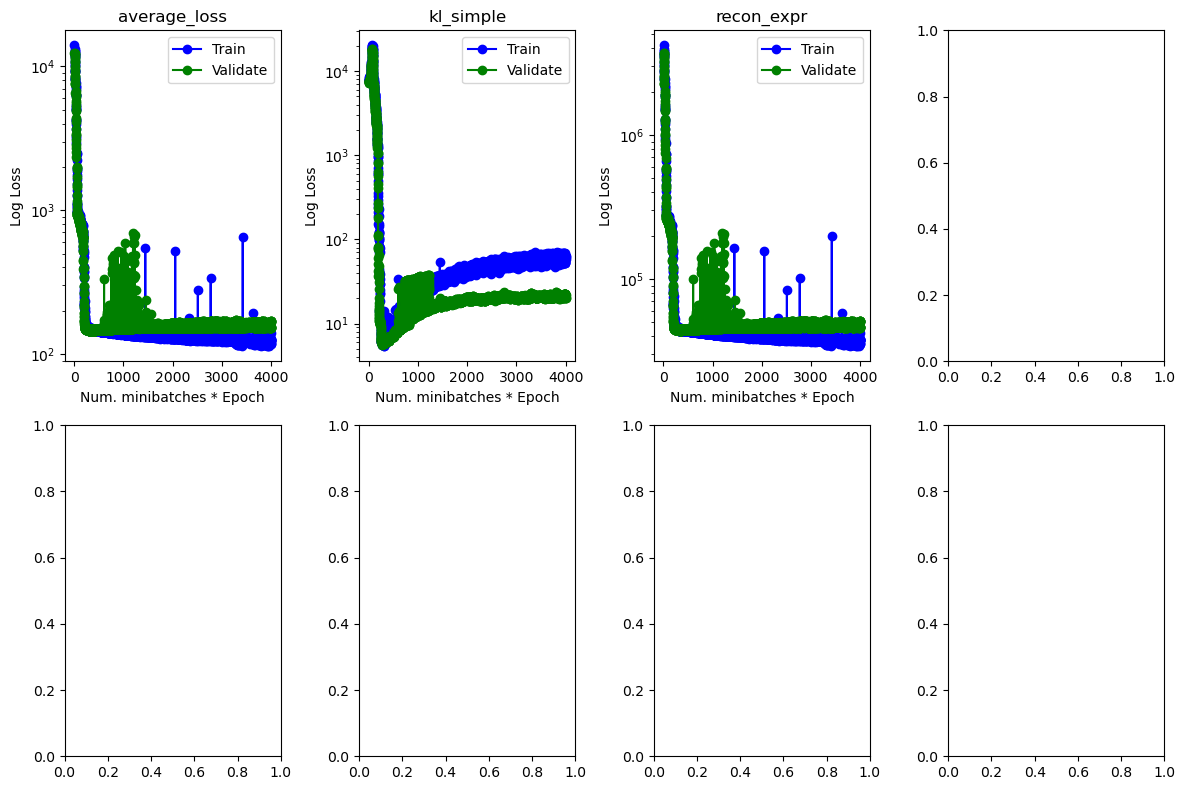

<Figure size 640x480 with 0 Axes>

In [3]:
pr = preffect.train()

When complete, PREFECT displays the change of all losses active during training. In this example:
- `average loss` (average of all active losses)
- `kl_lib` (Kullback–Leibler divergence of the latent space for library size)
- `kl_simple` or `kl_expr` (Kullback–Leibler divergence of the latent space for expression)
- `recon_lib` (Reconstruction loss of the learned library size)
- `recon_expr` (Reconstruction loss of the inferred counts)

------------------------------------------------------------------------------------

### Inference (passing data through the trained PREFFECT model):

Inference results will be found within factory object (`preffect.pr.inference_dict[inference_key]`)

In [ ]:
preffect.configs['input_inference_anndata_path'] = "/data/lab_vm/release/preffect/vignettes/simple/test/"
pr = preffect.inference(inference_key="test_dataset")

------------------------------------------------------------------------------------

### Clustering:

PREFFECT provides clustering tools to visualize the inferred results.

Options are: 
- `latent` (cluster on the latent space)
- `counts` (cluster on inferred counts)
- `true_counts` (cluster on the true counts used for training)

ir_name: Choose inference implementation (`endogenous` is the name assigned to an inference without batch adjustment)

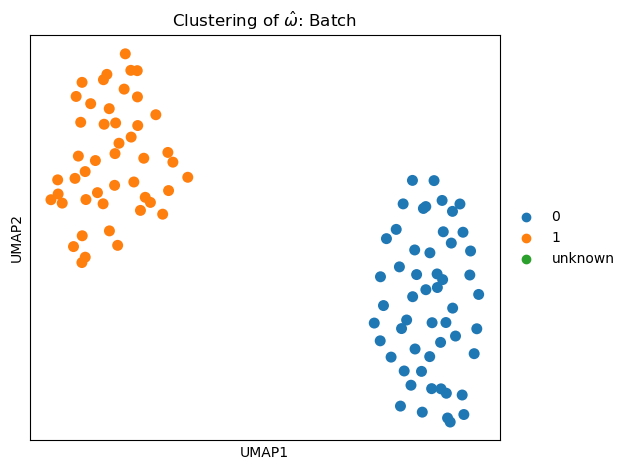

In [11]:
cl = preffect.visualize_embedding("counts", ir_name="test_dataset", cluster_omega=True)

PREFFECT has the option to perform Leiden clustering of the samples using the generated UMAP. 

Leiden clustering finds well-connected clusters from the UMAP embedding of your desired data point (inferred counts, true counts, or the latent space).

    batch leiden
0       0      0
1       1      1
2       1      1
3       1      1
4       0      0
..    ...    ...
95      0      0
96      1      1
97      1      1
98      1      2
99      1      2

[100 rows x 2 columns]


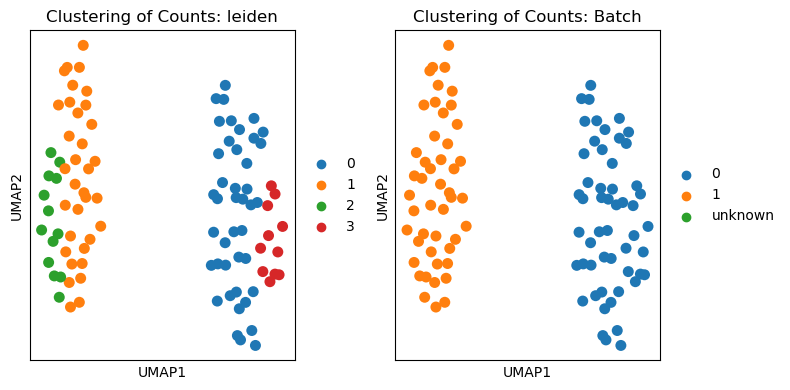

In [9]:
cl = preffect.generate_embedding("counts", ir_name="test_dataset")
print(preffect.cluster.leiden_assignment)

cl = preffect.visualize_embedding("counts", ir_name="test_dataset", perform_leiden=True)

------------------------------------------------------------------------------------

### Batch Adjustment:

PREFFECT allows one to adjust the model to treat all samples as if it were derived from a particular batch. 

In this dataset, two batches exist (batch 0 and 1). 

Here, we will set samples to all resemble "batch 0".

In [7]:
# set what batch you wish your samples be adjusted to
preffect.configs['adjust_vars'] = True
preffect.configs['adjust_to_batch_level'] = 0

inf = preffect.inference()

We can use visualization after adjusted inference to examine whether this has addressed the batch effect.

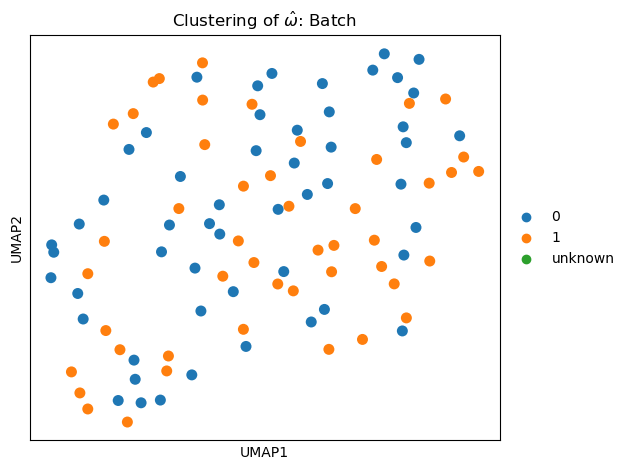

In [10]:
cl = preffect.visualize_embedding("counts", ir_name="inference_0", cluster_omega=True)